$$
\newcommand{\Oframe}{\mathcal{O}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\Uset}{\mathcal{U}}
\newcommand{\braces}[1]{\left\{#1\right\}}
\newcommand{\Rbot}{\mathcal{R}}
\newcommand{\Wspace}{\mathcal{W}}
\newcommand{\Wobs}{\mathcal{W}_{obs}}
\newcommand{\Wfree}{\mathcal{W}_{free}}
\newcommand{\Cspace}{\mathcal{C}}
\newcommand{\Cfree}{\mathcal{C}_{free}}
\newcommand{\Cobs}{\mathcal{C}_{obs}}
\newcommand{\numobs}{n_{obs}}
\newcommand{\qinit}{q_{init}}
\newcommand{\goal}{G}
$$

In [22]:
# IMPORT mypy LIBRARY ALLOWING TYPE ANNOTATION AND INFERENCE
from typing import List, Tuple, Set, Dict, Callable, Iterable, Any, NamedTuple
import itertools
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.patches import Circle as mplCircle
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = [10, 10]
%matplotlib inline

# The path planning problem

Consider a point robot, $\Rbot$ moving in a 2D workspace $\Wspace \subset \R^2$.  Let $\Oframe$ denote the 2D cartesian coordinate frame, which will also be called the *world coordinate frame*, or just *world frame*.  The configuration, $q$, of the point is the pair of numbers representing the coordinates of the point in the world frame
$$
\begin{equation}
q = (x, y) \,\, \in \,\, \R^2
\end{equation}
$$
The configuration space $\Cspace \subset \R^2$.  Consider $\numobs$ polygonal obstacles in the workspace.  The total region covered by these obstacles is the obstacle region $\Wobs$, and the corresponding region in the configuration space is denoted $\Cobs$.  The region of the configuration space not covered by obstacles is called the *free space*, $\Cfree$.   Note that for this 2D point robot, the workspace and configuration space are equivalent.  

The initial configuration of the robot is a configuration in free space, $\qinit \in \Cfree$.  

The *goal region*, $\goal$ is a subset of the free space, $\goal \in \Cfree$.

The above objects are often referred to all together as the *world*.

A *path* through the configuration space is a continuous function mapping arc length to a point in the configuration space
$$
\begin{equation}
\sigma: [0, L] \rightarrow \Cspace
\end{equation}
$$
where $L$ is the length of the path.  A path is a *feasible* if $\sigma(0) = \qinit$ and $\sigma(L) \in \goal$.

The *path planning* problem is to find a feasible path from $\qinit$ to $\goal$.

# An example world with obstacles

Consider a rectangular workspace defined by boundary vertices.  We will define a few data structures for convenience.  *Point* represent a point in the workspace, *Configuration* represents a point in the configuration space.  Note that these are the same for our simple 2D point robot, but in general, the workspace and configuration space are very different spaces.

In [23]:
class Point:
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y

    def __repr__(self):
        """ This is to allow printing this object. """
        fmtstr = "Point({:f}, {:f})"
        return fmtstr.format(self.x, self.y)

class Configuration:
    """
    A configuration of robot $\Rbot$.
    """
    def __init__(self, x: float, y: float) -> None:
        self.x = x
        self.y = y
        
    def __add__(self, other: 'Configuration') -> 'Configuration':
        """ This defines the '+' operator so we can add Configurations. """
        x = self.x + other.x
        y = self.y + other.y
        return Configuration(x, y)
    
    def __mul__(self, other: float) -> 'Configuration':
        x = self.x * other
        y = self.y * other
        return Configuration(x, y)
    
    def __rmul__(self, other: float) -> 'Configuration':
        return self.__mul__(other)
    
    def __repr__(self) -> None:
        """ Enable printing. """
        fmtstr = "Configuration({:f}, {:f})"
        return fmtstr.format(self.x, self.y)
    
    def __str__(self):
        fmtstr = "({:.2f}, {:.2f})"
        return fmtstr.format(self.x, self.y)

## Define a boundary

Let's define a 10 by 10 meter workspace.

In [24]:
boundary = [Point(-10, -10),
            Point(-10, 10),
            Point(10, 10),
            Point(10, -10)]

min_x = min([p.x for p in boundary])
max_x = max([p.x for p in boundary])
min_y = min([p.y for p in boundary])
max_y = max([p.y for p in boundary])

Let's start preparing some visualization functions.  Here we define a function to draw the workspace boundary.

In [25]:
def drawBoundary(boundary: List[Point]) -> Line2D:
    # def drawPath(path: PolylinePath, color: str) -> Line2D:
    xdata = [p.x for p in boundary] + [boundary[0].x]
    ydata = [p.y for p in boundary] + [boundary[0].y]
    line = Line2D(xdata, ydata, color="black", linewidth=3, zorder=1)
    return line

## Define obstacles

At first, let's consider circular obstacles.

In [26]:
class Circle:
    def __init__(self, x: float, y: float, r: float) -> None:
        self.p = Point(x, y)
        self.r = r
        
    def __repr__(self) -> str:
        return "Circle({}, {}, {})".format(self.p.x, self.p.y, self.r)

Let's define some helper functions to draw obstacles.

In [27]:
def drawObstacle(o: Circle) -> mplCircle:
    c = mplCircle((o.p.x, o.p.y), o.r, facecolor="red", edgecolor="red", alpha=0.5)
    return c

def drawObstacles(obstacles: List[Circle]) -> PatchCollection:
    patches = []
    for o in obstacles:
        patches.append(drawObstacle(o))
    collection = PatchCollection(patches, match_original=True)
    return collection

## Goal region

Let's define a circular goal region.

In [28]:
class Goal:
    def __init__(self, x: float, y: float, r: float) -> None:
        self.p = Point(x, y)
        self.r = r

And let's define a function to randomly select a goal region from the free space.  This will involve a helper function to check if a goal region is collision free.

In [29]:
def distancePointPoint(a: Point, b: Point) -> float:
    return math.sqrt((b.x - a.x)**2 + (b.y - a.y)**2)

def distanceGoalCircle(goal: Goal, c: Circle) -> float:
    return distancePointPoint(goal.p, c.p) - (goal.r + c.r)

def collisionFree(goal: Goal, obstacles: List[Circle]) -> bool:
    for o in obstacles:
        if distanceGoalCircle(goal, o) <= 0:
            return False
    return True

def getRandomGoal(boundary: List[Point], obstacles: List[Circle]) -> Goal:
    r = random.uniform(0.5, 1.0)
    x = random.uniform(min_x, max_x)
    y = random.uniform(min_y, max_y)
    goal = Goal(x, y, r)
    while not collisionFree(goal, obstacles):
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        goal = Goal(x, y, r)
    return goal

And some functions to draw the goal.

In [30]:
def drawGoal(g: Goal) -> mplCircle:
    c = mplCircle((g.p.x, g.p.y), g.r, facecolor="magenta", edgecolor="black", alpha=0.5)
    return c

Let's create $\numobs$ obstacles with random radii between 0.1 and 2.0 meters, and a random circular goal region.

(-15.0, 10.0, -15.0, 10.0)

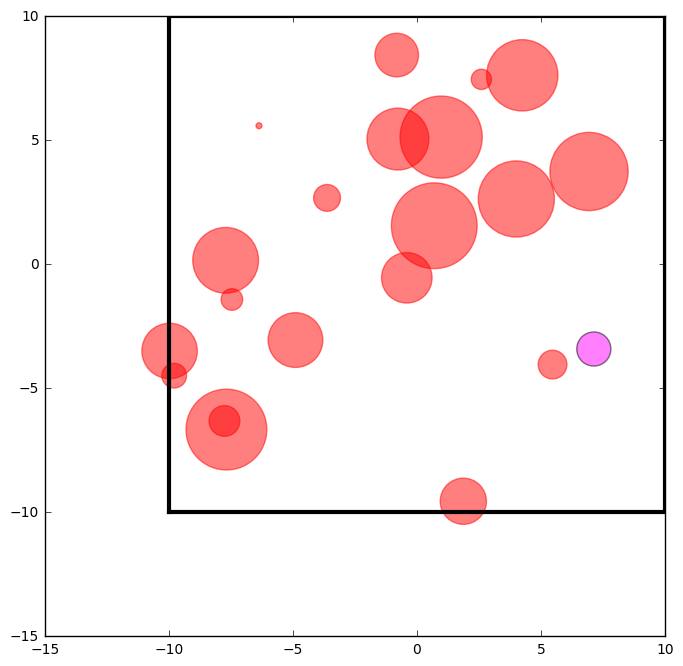

In [31]:
# DEFINE OBSTACLES
n_obs = 20
obstacles = []
for i in range(n_obs):
    c = Circle(random.uniform(min_x, max_x),
               random.uniform(min_y, max_y),
               random.uniform(0.1, 2.0))
    obstacles.append(c)

# DEFINE GOAL REGION
goal = getRandomGoal(boundary, obstacles)

# DRAW OBSTACLES AND GOAL
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.add_collection(drawObstacles(obstacles))
ax.add_line(drawBoundary(boundary))
ax.add_patch(drawGoal(goal))
ax.set_ylim((min_y - 1, max_y + 1))
ax.set_xlim((min_x - 1, max_x + 1))
plt.axis('equal')

# Sampling-based planning

We will now define the core functions that comprise traditional sampling-based planning methods.  In particular, we will focus on a method called *rapidly exploring random tree*, abbreviated RRT.  

The main data structure computed by RRT is a directed graph of configurations in the free space.  There are many ways to represent and encode a directed graph.  In the examples below we will often use two methods: (a) a dictionary representation, and (b) a tuple composed of a list of vertices and a list of edges, where an edge between two vertices is a tuple containing the vertices.  These two data types are formally defined below.

First, the dictionary representation:
$$
\begin{equation}
\text{directed graph as a dictionary: } \quad G: \braces{q \in \Cfree: [a \in \Cfree, \dots, b \in \Cfree]}
\end{equation}
$$
In our python implementation, using ```mypy``` syntax, the data structure can be defined as 

```python
G: Dict[Configuration, List[Configuration]
```

Second, the tuple of vertices and edges:
$$
\begin{equation}
G: (V, E) \quad s.t. \quad V \subset \Cfree, \quad E \in V \times V 
\end{equation}
$$
In our python implementation and using ```mypy``` syntax, this becomes

```python
G: Tuple(V, E)  where   V: List[Configuration], E: List[Tuple(Configuration, Configuration)]
```

The pseudocode for the RRT method is given below.

```python
def RRT(qinit,      # type: Configuration
        boundary,   # type: List[Point]
        obstacles,  # type: List[Circle]
        goal        # type: Goal
        ):
    V = [qinit]
    E = []
    G = (V, E)  # assume this is mutable
    q_new = qinit
    while q_new not in goal:
        q_rand = sampleFree(obstacles)
        q_near = nearest(G, q_rand)
        q_new = steer(q_near, q_rand)
        if collisionFreePath(q_near, q_new, obstacles):
            V.append(q_new)
            E.append((q_near, q_new))
    return G
```

## ```sampleFree()```

This function samples a random configuration from the free space such that for a sequence of sampled configurations, the configurations are independent and identically distributed.  A common assumption is that the underlying distribution is a uniform distribution over the free space.  We will also follow this in implementation.

An easy way to obtain a uniform distribution over the free space is to first sample uniformly from anywhere in the configuration space, and then ignore any samples that are (a) in collision with any obstacle or (b) are outside the configuration space boundary.

In [32]:
def sample() -> Configuration:
    """
    Sample a configuration that is inside the boundary.
    """
    # TODO: DON'T RELY ON GLOBAL VARS min_x, etc
    q = Configuration(random.uniform(min_x, max_x),
                      random.uniform(min_y, max_y))
    return q


def distanceConfigPoint(a: Configuration, b: Point) -> float:
    return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)


def distanceConfigCircle(q: Configuration, o: Circle) -> float:
    return distanceConfigPoint(q, o.p) - o.r


def inCollision(q: Configuration, obs: List[Circle]) -> bool:
    """
    Determine if q is in collision with any obstacle.
    """
    for o in obs:
        if distanceConfigCircle(q, o) <= 0:
            return True
    return False


def sampleFree(obstacles: List[Circle]) -> Configuration:
    """
    Sample a configuration from the free space uniformly.
    """
    q = sample()
    while inCollision(q, obstacles):
        q = sample()
    return q

## ```nearest()```

This function finds the nearest vertex in the graph G to a some other point $x \in \Cspace$.

In [33]:
# LET'S "typedef" GRAPH DATA STRUCTURE
Graph = Tuple[List[Configuration], 
              List[Tuple[Configuration, Configuration]]]


def distanceConfigConfig(a: Configuration, b: Configuration) -> float:
    """ Distance between two configurations."""
    return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)


def nearest(G: Graph, q: Configuration) -> Configuration:
    """ Compute nearest vertex in graph G to configuration q."""
    V, E = G
    v_nearest = V[0]
    d_nearest = math.inf
    for v in V[1:]:
        d = distanceConfigConfig(v, q)
        if d < d_nearest:
            v_nearest = v
    return v_nearest

## ```steer()```

Given two configurations $a, b \in \Cspace$, this function computes a point $c \in \Cspace$ that is closer to $b$ than $a$   is, while still staying within a ball of radius $\eta$ of a.  Note that $\eta$ is a *tuning parameter* of the RRT algorithm.

In [34]:
def steer(a,    # type: Configuration, 
          b,    # type: Configuration, 
          eta   # type: float
         ) -> Configuration:
    """ 
    Steer from a to b, by drawing a line from a to b 
    and moving along that line by a distance eta.
    """
    L = distanceConfigConfig(a, b)
    if eta < L:
        return (1.0 - eta) * a + eta * b
    else:
        return b

## ```collisionFreePath()```

Given two configurations $a, b \in \Cfree$, this function checks to see if the straight line path between $a$ and $b$ is collision free, i.e. does not intersect any obstacles.

In [35]:
def distanceCircleCircle(a: Circle, b: Circle) -> float:
    return distancePointPoint(a.p, b.p) - (a.r + b.r)


def circleInCollision(c: Circle, obs: List[Circle]) -> bool:
    """
    Determine if circle c is in collision with any obstacle.
    """
    for o in obs:
        if distanceCircleCircle(c, o) <= 0:
            return True
    return False


def collisionFreePath(a,    # type: Configuration 
                      b,    # type: Configuration
                      obs   # type: List[Circle]
                      ) -> bool:
    # COVER STRAIGHT LINE FROM a TO b WITH CIRCLES
    L = distanceConfigConfig(a, b)
    sample_spacing = 0.2
    circles = []   # type: List[Circle]
    s = 0.2
    while s < L:
        q = (1.0 - s) * a + s * b
        c = Circle(q.x, q.y, sample_spacing)
        if circleInCollision(c, obs):
            return False
        s += sample_spacing
    # TODO: MAKE BINARY SEARCH
    return True

## ```RRT()```

We are now ready to define the actual RRT function.

In [36]:
def distanceConfigGoal(q: Configuration, goal: Goal) -> float:
    """ Compute distance from configuration q to goal."""
    return distanceConfigPoint(q, goal.p) - goal.r


def RRT(qinit,      # type: Configuration
        boundary,   # type: List[Point]
        obstacles,  # type: List[Circle]
        goal        # type: Goal
        ) -> Graph:
    # TUNING PARAMETER FOR steer() FUNCTION
    eta = 0.3
    
    # INITIALIZE GRAPH WITH JUST ONE VERTEX, qinit
    V = [qinit]  # type: List[Configuration]
    E = []       # type: List[Tuple[Configuration, Configuration]]
    # BEGIN EXPANDING GRAPH
    q_new = qinit
    while distanceConfigGoal(q_new, goal) > 0:
        q_rand = sampleFree(obstacles)
        q_near = nearest((V, E), q_rand)
        q_steer = steer(q_near, q_rand, eta)
        if collisionFreePath(q_near, q_steer, obstacles):
            q_new = q_steer
            V.append(q_new)
            E.append((q_near, q_new))
    return (V, E)

In [37]:
def drawGraphVertex(q: Configuration) -> mplCircle:
    radius = 0.1
    c = mplCircle((q.x, q.y), radius, facecolor="green", edgecolor="green", alpha=1.0)
    return c

def drawGraphVertices(vertices: List[Configuration]) -> PatchCollection:
    patches = []
    for v in vertices:
        patches.append(drawGraphVertex(v))
    collection = PatchCollection(patches, match_original=True)
    return collection


def drawGraph(G: Graph) -> Tuple[LineCollection, PatchCollection]:
    V, E = G
    segments = []
    nodes = []
    for edge in E:
        a, b = edge
        line = [(a.x, a.y), (b.x, b.y)]
        segments.append(line)
    vertCollection = drawGraphVertices(V)
    edgeCollection = LineCollection(segments, color=(0., 0., 0., 1.0))
    return edgeCollection, vertCollection

def drawConfig(q: Configuration) -> mplCircle:
    radius = 0.25
    c = mplCircle((q.x, q.y), radius, facecolor="blue", edgecolor="blue", alpha=0.5)
    return c

160


(-15.0, 10.0, -15.0, 10.0)

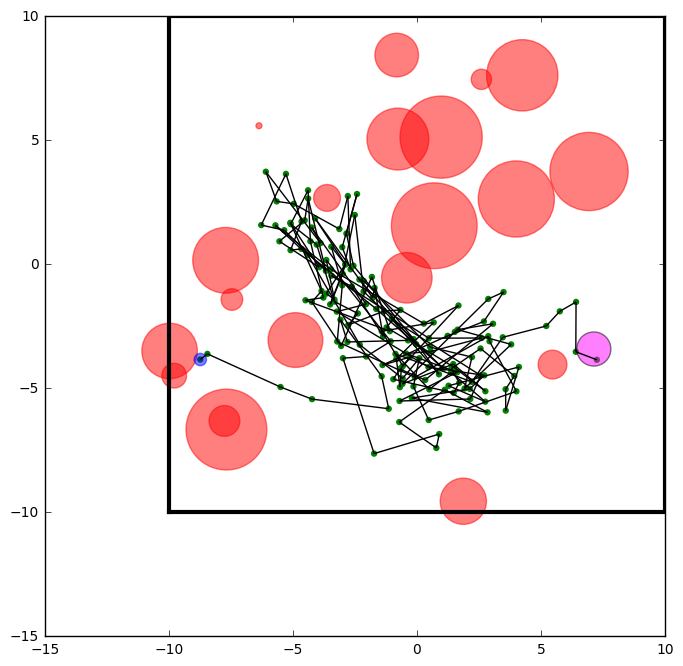

In [41]:
qinit = sampleFree(obstacles)
G = RRT(qinit, boundary, obstacles, goal)
print(len(G[0]))

# DRAW OBSTACLES AND GOAL
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.add_collection(drawObstacles(obstacles))
ax.add_line(drawBoundary(boundary))
ax.add_patch(drawGoal(goal))
ax.add_patch(drawConfig(qinit))
lcol, vcol = drawGraph(G)
ax.add_collection(lcol)
ax.add_collection(vcol)
ax.set_ylim((min_y - 1, max_y + 1))
ax.set_xlim((min_x - 1, max_x + 1))
plt.axis('equal')